In [19]:
import os
from PIL import Image
from pathlib import Path
import torch as t
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import Generator
import Discriminator
import matplotlib.pyplot as plt


In [4]:
class AlphaMattingDataset(Dataset):
    def __init__(self, input_dir, gt_dir, trimaps):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.trimaps = trimaps
        self.images = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.input_dir, self.images[idx])
        tri_name = os.path.join(self.trimaps, "Trimap1/" + self.images[idx])
        gt_name = os.path.join(self.gt_dir, self.images[idx])

        image = Image.open(img_name).convert("RGB")
        tri_image = Image.open(tri_name).convert("L")
        gt_image = Image.open(gt_name).convert("L")

        image = transformer(image)
        tri_image = transformer(tri_image)
        gt_image = transformer(gt_image)

        return image, tri_image, gt_image

class TestDataset(Dataset):
    def __init__(self, input_dir, trimap_dir, transform=None):
        self.input_dir = Path(input_dir)
        self.trimap_dir = Path(trimap_dir)
        self.transform = transform
        self.images = list(self.input_dir.glob('*.png'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = img_path.stem
        img = Image.open(img_path).convert("RGB")
        trimap = Image.open(self.trimap_dir / (img_name + '.png')).convert("L")

        if self.transform:
            img = self.transform(img)
            trimap = self.transform(trimap)

        return img, trimap

In [32]:
transformer = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(320)])
# Train Dataset
train_dataset = AlphaMattingDataset(input_dir='Data/Train/InputImages', gt_dir='Data/Train/GroundTruthAlphas',
                                    trimaps='Data/Train/Trimaps')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Test Dataset
test_dataset = TestDataset(input_dir="Data/Test/InputImages", trimap_dir="Data/Test/Trimaps", transform=transformer)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [26]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

epochs = 1
lr_g = 0.001
lr_d = 0.001

In [8]:
if t.cuda.is_available():
    device = t.device("cuda")
# elif t.backends.mps.is_built():
#     device = t.device("mps")
else:
    device = t.device("cpu")

print(device)

cpu


In [9]:
generator = Generator.Generator().to(device)
discriminator = Discriminator.PatchGANDiscriminator(patch_size=4).to(device)

optim_g = t.optim.Adam(generator.parameters(), lr=0.001)
optim_d = t.optim.Adam(discriminator.parameters(), lr=0.001)

l1_loss = t.nn.SmoothL1Loss().to(device)
mse_loss = t.nn.MSELoss().to(device)

In [10]:
for epoch in range(epochs):
    for image, tri_image, gt_image in train_loader:
        image = image.to(device)
        tri_image = tri_image.to(device)
        gt_image = gt_image.to(device)
        input_img = t.cat((image, tri_image), dim=1).to(device)

        # Train discriminator
        optim_d.zero_grad()

        real_alpha_pred = discriminator(t.cat((image, gt_image), dim=1))
        d_real_loss = mse_loss(real_alpha_pred, t.ones_like(real_alpha_pred))

        fake_alpha = generator(input_img)
        fake_alpha_pred = discriminator(t.cat((image, fake_alpha.detach()), dim=1))
        d_fake_loss = mse_loss(fake_alpha_pred, t.zeros_like(fake_alpha_pred))

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optim_d.step()

        # Train generator
        optim_g.zero_grad()

        fake_alpha = generator(input_img)
        g_l1_loss = l1_loss(fake_alpha, gt_image)

        fake_alpha_pred = discriminator(t.cat((image, fake_alpha), dim=1))
        g_gan_loss = mse_loss(fake_alpha_pred, t.ones_like(fake_alpha_pred))

        g_loss = g_l1_loss + g_gan_loss
        g_loss.backward()
        optim_g.step()

    print(f"Epoch {epoch + 1}")

Epoch 1


In [11]:
generator.eval()
discriminator.eval()

PatchGANDiscriminator(
  (model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [45]:
test_dataset = TestDataset(input_dir="Data/Test/InputImages", trimap_dir="Data/Test/Trimaps/Trimap1", transform=transformer)

if len(test_dataset) > 0:
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
else:
    print("Dataset is empty. Check the paths and data.")

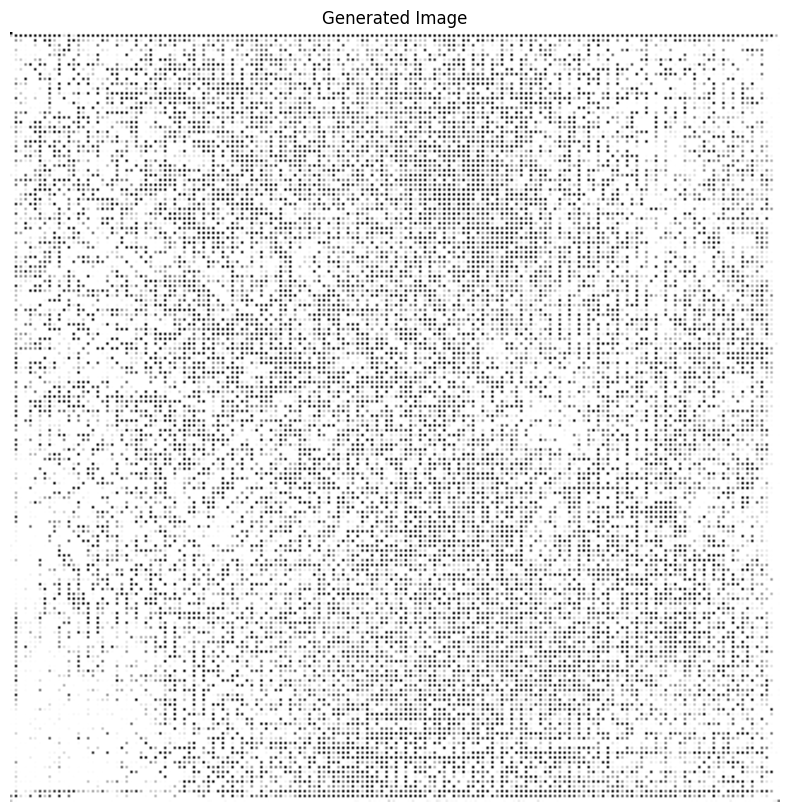

In [44]:
generator.eval()

images, tri_images = next(iter(test_loader))
image = images[0:1].to(device)
tri_image = tri_images[0:1].to(device)

input_img = t.cat((image, tri_image), dim=1).to(device)

with t.no_grad():
    fake_alpha = generator(input_img)

fake_alpha_np = fake_alpha.squeeze().cpu().numpy()


plt.figure(figsize=(10, 10))
plt.imshow(fake_alpha_np, cmap='gray')  # Assuming the output is a grayscale image
plt.title("Generated Image")
plt.axis('off')
plt.show()